### Практическая работа к уроку №4

#### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

Реализованные критерии останова:
1. min_leaf - минимальное количество объектов в узле
2. max_depth - максимальная глубина дерева
3. one_class_per_leaf - останов в случае, когда все объекты в листе относятся к одному классу.

#### 2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

Реализовано в одной функции, выбор делается при объявлении дерева как параметр функции build_tree

In [256]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
import math

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2, 
    n_classes=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.75,
    random_state=5
)

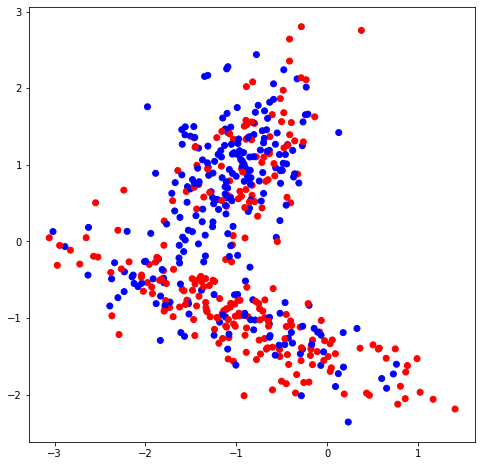

In [4]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [209]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [210]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [211]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчет энтропии
def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * math.log(p, 2)
        
    return impurity

In [212]:
# Расчет качества

def quality(left_labels, right_labels, current_criterion, criterion):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    if criterion == 'gini':
        left_criterion = gini(left_labels)
        right_criterion = gini(right_labels)
    elif criterion == 'entropy':
        left_criterion = entropy(left_labels)
        right_criterion = entropy(right_labels)
    
    return current_criterion - p * left_criterion - (1 - p) * right_criterion

In [213]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [214]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, criterion, min_leaf=None):  
    if criterion == 'gini':
        current_criterion = gini(labels)
    elif criterion == 'entropy':
        current_criterion = entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            if min_leaf:
                #  пропускаем разбиения, в которых в узле остается менее min_leaf объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue
            
            current_quality = quality(true_labels, false_labels, current_criterion, criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [215]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, criterion, min_leaf=None, max_depth=None, one_class_per_leaf=False):
    assert criterion in ['gini', 'entropy'], "not valid criterion"
    
    if max_depth:
        max_depth -= 1
        
    quality, t, index = find_best_split(data, labels, criterion, min_leaf=min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if (quality == 0 or 
        max_depth == 0):
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    if one_class_per_leaf:
        if len(true_labels) == 0 or len(false_labels) == 0:
            return Leaf(data, labels)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels,
                             criterion,
                             min_leaf=min_leaf,
                             max_depth=max_depth, 
                             one_class_per_leaf=one_class_per_leaf)
    false_branch = build_tree(false_data, false_labels,
                              criterion,
                              min_leaf=min_leaf,
                              max_depth=max_depth,
                              one_class_per_leaf=one_class_per_leaf)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [216]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [217]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [218]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data, classification_labels, test_size = 0.3, random_state = 1
)

In [ ]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

In [253]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

def metrics(my_tree, train_data, test_data, train_labels, test_labels):
    # Получим ответы для обучающей и тестовой выборки 
    train_answers = predict(train_data, my_tree)
    answers = predict(test_data, my_tree)
    
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, answers)
    
#     print(f"Train accuracy: {train_accuracy}\n"
#          f"Test accuracy: {test_accuracy}\n")
    return train_accuracy, test_accuracy 

In [250]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def visualize_tree(my_tree, train_data, test_data, train_labels,
                   test_labels, train_accuracy, test_accuracy):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    
    plt.show();

#### 2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

Реализованные критерии останова:
1. min_leaf - минимальное количество объектов в узле
2. max_depth - максимальная глубина дерева
3. one_class_per_leaf - останов в случае, когда все объекты в листе относятся к одному классу.

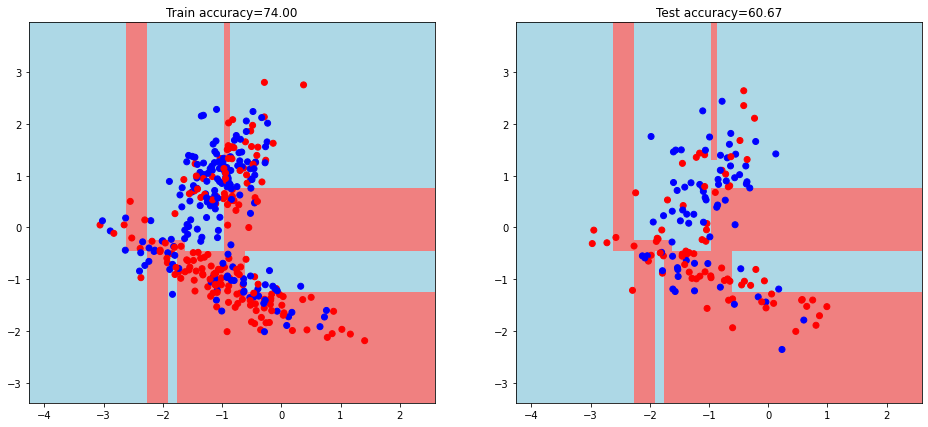

In [264]:
my_tree = build_tree(train_data, train_labels, criterion='gini', min_leaf=4, max_depth=6)
train_acc, test_acc = metrics(my_tree, train_data, test_data, train_labels, test_labels)
visualize_tree(my_tree, train_data, test_data, train_labels, test_labels, train_acc, test_acc)

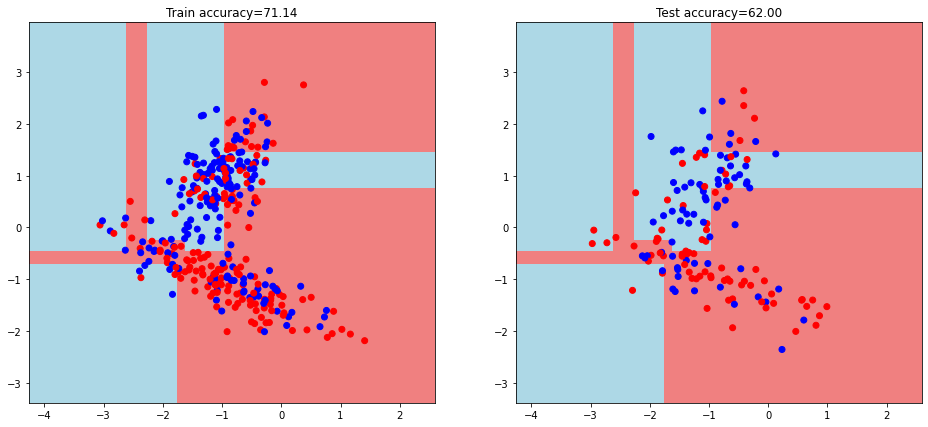

In [263]:
my_tree = build_tree(train_data, train_labels, criterion='entropy', min_leaf=4, max_depth=6)
train_acc, test_acc = metrics(my_tree, train_data, test_data, train_labels, test_labels)
visualize_tree(my_tree, train_data, test_data, train_labels, test_labels, train_acc, test_acc)

При одинаковых гиперпараметрах дерево обученное с использованием энтропийного критерия достигло более высокого качества и при этом меньше переобучилось

3 [опция]. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.